End-to-End text summarization model

In [26]:
'''
Steps : 

1. Word Embeddings
2. Multi-Head Self Attention Mechanism 
3. Rotary Positional Encoding
4. RMSNormalization
5. SwiGLU activation
6. Decoder and Transformer Model
'''

'\nSteps : \n\n1. Word Embeddings\n2. Multi-Head Self Attention Mechanism \n3. Rotary Positional Encoding\n4. RMSNormalization\n5. SwiGLU activation\n6. Decoder and Transformer Model\n'

In [27]:
# imports 
import tensorflow as tf
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
# Word Embeddings 
'''A word embedding is a numerical representation of a word in a high-dimensional space.
The key idea behind this representation is that words with similar meanings will have similar numerical representations,
meaning the “distance” between their embeddings in this space will be small.'''

class TokenEmbedding(tf.keras.layers.Layer):
    """
    Args:
        vocab_size(int): Vocabulary size(number of unique tokens).
        d_model (int): Embedding dimension
    """
    def __init__(self,vocab_size,d_model):
        super().__init__()

        #Learnable token embeddings
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=d_model,
            mask_zero=True   # padding token is masked
        )

    def compute_mask(self,*args,**kwargs):
        # Pass through the mask from embedding layer
        return self.embedding.compute_mask(*args,**kwargs)

    def call(self,x):
        """
        Args:
            x: Tensor of token indices -> shape: (batch_size,sequence_length)
        
        Returns:
            Tensor of shape (batch_size,sequence_length,d_mask)
        """

        # COnvert token indices to dense vectorss -> (batch_size,seq_len,d_model)
        x=self.embedding(x)
        return x
    
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Creates a learnable positional embedding.
    """
    def __init__(self, max_len, d_model):
        super().__init__()
        # Embedding layer for positions 0 to max_len-1
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_len, output_dim=d_model)
        self.max_len = max_len

    def call(self, x):
        """
        Args:
            x: Token embeddings of shape (B, T, D)
        Returns:
            Positional embeddings of shape (B, T, D)
        """
        # Get the sequence length (T) from the input tensor
        T = tf.shape(x)[1] 
        # Create position indices: [0, 1, 2, ..., T-1]
        positions = tf.range(start=0, limit=T, delta=1)
        # Broadcast to match the batch size: (B, T)
        positions = tf.broadcast_to(positions, [tf.shape(x)[0], T])
        # Look up the positional embeddings
        return self.pos_emb(positions)

In [29]:
# Multi-head self attention
"""It captures multiple meaning in a sentence.
The philosphy is each attention head can focus on different parts of the input.
One head might focus on local context (e.g., next word)
Another might look at global structure (e.g., sentence-level relationships)."""

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Llama multi-head(scaled-dor-product) attention implemented from scratch.

    Args: 
        d_model (int) : total embedding size ( must be divisible by num_heads)
        num_heads(int): number of attention heads
        dropout(float): dropout on attenstion weights ( 0.0 = not dropout)
    
    Call signature :
        T_q = T_k = T_v

        output, attn_scores = mha(
        query,                     # (Batch_size, T_q, d_model)
        value=None,                # (B, T_v, d_model)  – defaults to query
        key=None,                  # (B, T_k, d_model)  – defaults to value
        mask=None,                 # (B, 1, T_q, T_k) or (B, T_q, T_k)
        use_causal_mask=False,     # True → autoregressive causal mask
        training=None
        )
    """

    def __init__(self,d_model,num_heads,dropout=0.0,**kwargs):
        super().__init__(**kwargs)

        if d_model % num_heads!=0 :
            raise ValueError (
                f"d_model={d_model} must be divisible by num_heads={num_heads}"
            )
        self.d_model =d_model
        self.num_heads =num_heads
        self.depth =d_model/num_heads

        # Linear projections fro Q,K,V and dinal output 
        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wo = tf.keras.layers.Dense(d_model,use_bias=False)

        self.dropout= tf.keras.layers.Dropout(dropout)

    # Helper Functions

    def _split_heads(self,x,B):
        """
        Reshape (Batch_size,sequence length,d_model) -> (Batch_size,num_heads,sequence length,depth)
        so we can run attention on each head in parallel
        """
        x - tf.reshape(x,(B,-1,self.num_heads,self.depth))  # x = (B, T, d_model)
        return tf.transpose(x,perm=[0,2,1,3])
    
    @staticmethod
    def _scaled_dot_product_attention(q,k,v,mask,dropout,training=None):
        """
        Core attention: softmax(QKᵀ / √d_k) V
        Returns: (B, num_heads, T_q, depth_v), (B, num_heads, T_q, T_k)
        """
        dk=tf.cast(tf.shape(k)[-1],tf.float32)
        scores=tf.matmul(q,k,transpose_b=True)/tf.math.sqrt(dk)  #(B,h,T_q,T_k)

        if mask is not None:
            # broadcast automatically if mask rank < scores rank
            scores+= (mask*-1e9)  # large negative = zero probability
    
        attn=tf.nn.softmax(scores,axis=-1) 
        attn=dropout(attn,training=training)
        output=tf.matmul(attn,v)  #(B,h,T_q,depth)
        return output
    
    # Forward Pass

    def call(
            self,
            query,
            value=None,
            key=None,
            mask=None,
            use_casual_mask=False,
            training=None
            ):
        if value is None:
            value = query
        if key is None:
            key = value
        B = tf.shape(query[0])

In [30]:
# Rotary Positional Encoding
"""
mathematical way to incorporate postional information of words in a text directly in attention mechanism.
The same word at different positions ends up with different rotated vectors
The inner product between tokens reflects their relative distances"""

def apply_rope(x,sin,cos):
    '''
    x : (B,h,T,d)   even-sized last dim ( d must be multiple of 2)
    sin: (T,d//2)   broadcastable
    cos: (T,d//2)
    '''
    # this seperates each features vector's dimension ito 2 halves - real and imaginary
    x_even = x[...,0::2] # get even-dimension values -> shape: (B,h,T,d/2)
    x_odd = x[...,1::2]  # get odd-dimension values -> shape: (B,h,T,d/2)

    # this is 2D rotation formulas applied to each positional index and head.
    # it rotates the embedding vector in its dimensional space based on position

    x_rot_even = x_even*cos-x_odd*sin
    x_rot_odd = x_even*sin-x_odd*cos

    x_rot = tf.stack([x_rot_even,x_rot_odd],axis=-1)
    return tf.reshape(x_rot,tf.shape(x))

def make_sincos(seq_len,dim,base=10000):
    """
    Returns sin , cos with shape (seq_len,dim//2)
    """
    pos = tf.cast(tf.range(seq_len),tf.float32)
    i = tf.cast(tf.range(0,dim,2),tf.float32)/dim
    theta = pos[:,None]/(base**i[None,:])
    return tf.sin(theta),tf.cos(theta)


In [31]:
# RMSNorm = Root Mean Square Normalization
'''
1) normalizes only by the vector magnitude (RMS) 
2) does not subtract the mean
3) uses a learnable scale parameter γ (but no bias)

        ┌───────────────┐
x ───►  │   RMSNorm     │
        └──────┬────────┘
               ▼
        ┌───────────────┐
        │ Multi-Head Att│   (causal masked)
        └──────┬────────┘
               ▼
        ┌───────────────┐
        │ Residual Add  │  x + attention(x)
        └───────────────┘
               ▼
           output

'''

class RMSNorm(tf.keras.layers.Layer):
    def __init__(self,hidden_size,epsilon=1e-8,**kwargs):
        super(RMSNorm,self).__init__(**kwargs)
        self.hidden_size= hidden_size
        self.epsilon = epsilon 

        # Learnable scale parameter γ (same shape as last dim of input)
        self.scale = self.add_weight(
        name="scale",
        shape=(self.hidden_size,),
        initializer=tf.ones_initializer(),  
        trainable=True,
    )

    
    def call(self,x):
        rms = tf.sqrt(tf.reduce_mean(tf.square(x),axis=-1,keepdims=True)+self.epsilon)
        norm_x =x/rms
        return norm_x*self.scale
    
class CasualSelfAttention(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dropout=0.0):
        super().__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )

        self.rmsnorm = RMSNorm(d_model)

    def call(self, x, padding_mask=None, training=None):
        norm_x = self.rmsnorm(x)

        # MultiHeadAttention expects mask shape: (batch, 1, 1, seq_len)
        attn = self.mha(
            query=norm_x,
            value=norm_x,
            key=norm_x,
            attention_mask=padding_mask,
            use_causal_mask=True,
            training=training
        )

        return x + attn   # residual connection


In [32]:
# SwiGLU activation
'''
1. SwiGLU is a gated activation function — short for Swish-Gated Linear Unit.
2. Gating helps model learn which features to keep/ignore.
3. Swish is smoother and empirically better than ReLU or GELU

Formula:
x1 , x2 are two linear projections of same input :
        Swish(x)  = x.sigmoid(x)
        SwiGLU(x) = Swish(x1).x2
'''
class SwiGLU(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, factor=4):
        super().__init__()

        inner_dim = hidden_dim * factor

        # GLU requires projection to 2 * inner_dim
        self.w1 = tf.keras.layers.Dense(2 * inner_dim, use_bias=False)
        self.w2 = tf.keras.layers.Dense(hidden_dim, use_bias=False)

    def call(self, x):
        x_proj = self.w1(x)
        x1, x2 = tf.split(x_proj, num_or_size_splits=2, axis=-1)  # (a, b)

        return self.w2(x1 * tf.nn.silu(x2))  # SwiGLU

In [33]:
# Decoder And Transformer Base Code

class FeedForward(tf.keras.layers.Layer):
    def __init__(self,d_model,dropout_rate=0.1):
        super().__init__()

        self.seq =tf.keras.Sequential(
            [
                SwiGLU(d_model),
                tf.keras.layers.Dropout(dropout_rate)
            ]
        )
        self.rmsnorm =RMSNorm(d_model)

    def call(self,x,training=None):
        y =self.seq(self.rmsnorm(x),training=training)  # pre-norm
        return x+y                                      # residual on raw x
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CasualSelfAttention(num_heads=num_heads,d_model=d_model,dropout=dropout_rate)
        self.ffn = FeedForward(d_model)
        
    def call(self,x,padding_mask=None,training=None):
        x = self.causal_self_attention(x, padding_mask=padding_mask, training=training)
        x = self.ffn(x, training=training)
        return x
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*,num_layers,d_model,num_heads,vocab_size,max_len,dropout_rate=0.1): # Added max_len
        super(Decoder,self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.token_embedding = TokenEmbedding(vocab_size=vocab_size,d_model=d_model) # Renamed
        self.pos_embedding = PositionalEmbedding(max_len=max_len, d_model=d_model)   # ADDED
        self.dropout =tf.keras.layers.Dropout(dropout_rate)

        self.dec_layers = [DecoderLayer(d_model=d_model,num_heads=num_heads,dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.last_attn = None

    def call(self, x, training=None):
        # Get padding mask from the *token* embedding layer
        pad_mask = self.token_embedding.compute_mask(x)
        if pad_mask is not None:
            pad_mask = tf.cast(~pad_mask, tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Create token embeddings
        x_tok = self.token_embedding(x)
        # Create positional embeddings (shape is inferred from x_tok)
        x_pos = self.pos_embedding(x_tok) 

        # ADD the two embeddings together
        x = x_tok + x_pos
        x = self.dropout(x, training=training)

        for layer in self.dec_layers:
            x = layer(x, padding_mask=pad_mask, training=training)

        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads,max_len, input_vocab_size, dropout_rate=0.1):
        super().__init__()

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            vocab_size=input_vocab_size,
            max_len=max_len,
            dropout_rate=dropout_rate,
        )

        self.rmsnorm = RMSNorm(d_model)
        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs,training=False):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        x = inputs

        x = self.decoder(x,training=training)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        x = self.rmsnorm(x)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output
        return logits

In [34]:
# Data Preparation 

df1 = pd.read_excel("datasets/Inshorts Cleaned Data.xlsx").dropna(subset=['Headline','Short']).rename(columns={'Headline':'target_txt','Short':'input_txt'})[['target_txt','input_txt']]
df2 = pd.read_csv('datasets/train.csv').rename(columns={'dialogue':'input_txt','summary':'target_txt'})[['target_txt','input_txt']]
df3 = pd.read_csv('datasets/samsum-train.csv').rename(columns={'dialogue':'input_txt','summary':'target_txt'})[['target_txt','input_txt']]

train_df = pd.concat([df1,df2,df3]).reset_index(drop=True)

# Text Cleaning 
def clean_text(text: str) -> str:
    """
    Remove HTML,normalize whitespace,preserve puntuation/numbers/casing
    """
    try:
        # text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9.,!?]+', ' ', text)
        text = text.replace('\r', ' ').replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        return text.strip().lower()
    except:
        return text
    
train_df["target_txt"] = train_df["target_txt"].apply(lambda x: clean_text(x))
train_df["input_txt"] = train_df["input_txt"].apply(lambda x: clean_text(x))

# Combine summary + dialogue and split on whitespace
raw_lens = [
    len(f"{s} {d}".split())
    for s, d in tqdm(zip(train_df["target_txt"], train_df["input_txt"]), total=len(train_df))
]

lens = np.array(raw_lens)

# Print summary stats
def pct(x): return np.percentile(lens, x)

print(f"Total examples    : {len(lens):,}")
print(f"Min / Max words   : {lens.min()} / {lens.max()}")
print(f"Mean ± std        : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- Percentiles (word count per raw text pair) ---")
for p in [50, 90, 95, 98, 99]:
    print(f"{p:>3}% : {pct(p):.0f} words")

MAX_LEN = int(pct(90))

text_pairs = []

for i,j in zip(train_df.input_txt,train_df.target_txt):
    try:
        if len(i.split(" ")+j.split(" ")) < MAX_LEN:       # BOS, SEP,EOS extra
            text_pairs.append((i,j))
    except:
        pass

100%|██████████| 82296/82296 [00:00<00:00, 357186.26it/s]


Total examples    : 82,296
Min / Max words   : 7 / 1164
Mean ± std        : 93.4 ± 58.7
--- Percentiles (word count per raw text pair) ---
 50% : 73 words
 90% : 164 words
 95% : 218 words
 98% : 284 words
 99% : 330 words


1000



2000



3000



4000



6000



8000



10000



12000



16000



20000





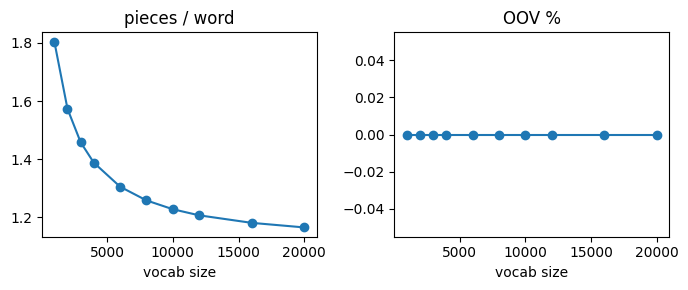

In [35]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

rng =np.random.default_rng(42)
valid_mask = rng.random(len(train_df)) < 0.05 
train_df_,valid_df = train_df[~valid_mask],train_df[valid_mask]

valid_texts = [f"{s} {d}" for s,d in zip(valid_df["target_txt"],valid_df["input_txt"])]

def train_tokenizer(text_iter,vocab_size: int) -> Tokenizer :
    tok = Tokenizer(models.BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size,min_frequency=2,special_tokens=["[Unk]"])
    tok.train_from_iterator(text_iter,trainer)
    return tok

def avg_pieces_per_word(tok: Tokenizer,texts) -> float:
    pieces = words = 0
    for t in texts:
        ids   = tok.encode(t).ids
        pieces += len(ids)
        words  += len(t.split())
    return pieces / words

vocab_sizes = [1000,2000,3000,4000,6000,8000,10000,12000,16000,20000]
pieces_per_word, oov_rate = [], []

for k in vocab_sizes:
    print(k)
    train_iter = (f"{s} {d}" for s, d in
                  zip(train_df_["target_txt"], train_df_["input_txt"]))
    tok = train_tokenizer(train_iter, k)

    # 1) average sub-words per word on validation set
    pieces_per_word.append(avg_pieces_per_word(tok, valid_texts))

    # 2) OOV percentage on validation set
    unk_id = tok.token_to_id("[UNK]")
    total = unk = 0
    for t in valid_texts:
        ids   = tok.encode(t).ids
        total += len(ids)
        unk   += sum(id_ == unk_id for id_ in ids)
    oov_rate.append(100 * unk / total)

# ── plot ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(vocab_sizes, pieces_per_word, marker='o')
plt.title("pieces / word"); plt.xlabel("vocab size")

plt.subplot(1,2,2)
plt.plot(vocab_sizes, oov_rate, marker='o')
plt.title("OOV %"); plt.xlabel("vocab size")

plt.tight_layout(); plt.show()

In [36]:
VOCAB_SIZE = 4000

CORPUS_FILE = 'all_texts.txt'
SPECIAL_TOKENS = ['[PAD]', '[UNK]', '[BOS]', '[EOS]','[SEP]']

with open(CORPUS_FILE, 'w', encoding='utf-8') as f:
    for _, row in train_df.iterrows():
        f.write(str(row['target_txt']) + ' ' + str(row['input_txt']) + '\n')

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

# Initialize and train
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=SPECIAL_TOKENS)
tokenizer.train([CORPUS_FILE], trainer)

# 3) Configure post-processing, padding & truncation ------------------
pad_id = tokenizer.token_to_id('[PAD]')
unk_id = tokenizer.token_to_id('[UNK]')
bos_id = tokenizer.token_to_id('[BOS]')
eos_id = tokenizer.token_to_id('[EOS]')
sep_id = tokenizer.token_to_id('[SEP]')

# Add BOS/EOS around single sequences
tokenizer.post_processor = TemplateProcessing(
    single='[BOS] $A [SEP]',
    pair='[BOS] $A [SEP] $B [EOS]',
    special_tokens=[('[BOS]', bos_id), ('[EOS]', eos_id),('[SEP]', sep_id)],
)

100%|██████████| 82296/82296 [00:09<00:00, 9104.98it/s] 


Total samples    : 82,296
Min / Max tokens : 12 / 1470
Mean ± std       : 131.4 ± 75.3
--- percentiles (tokens) ---
 50% : 108
 90% : 217
 95% : 287
 98% : 374
 99% : 440


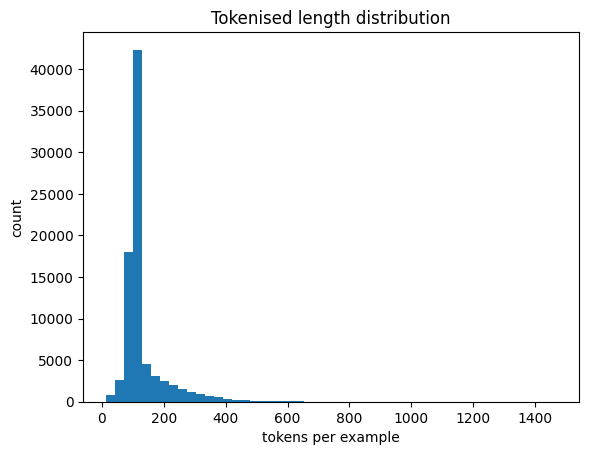

In [37]:
# ------------------------------------------------------------
# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for s, d in tqdm(zip(train_df["target_txt"], train_df["input_txt"]),
                 total=len(train_df)):
    txt   = f"{s} {d}"
    ids   = tok.encode(txt).ids
    lens.append(len(ids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [38]:
BATCH_SIZE = 8
MAX_LEN = int(pct(p))

# 0) Configure your tokenizer *once* at startup, not per-example
tokenizer.enable_truncation(
    max_length=MAX_LEN
)

tokenizer.enable_padding(
    pad_id=pad_id,
    pad_token='[PAD]',
    length=MAX_LEN
)

def encode_text(texts, max_length=MAX_LEN):
    encodings = tokenizer.encode(texts)
    return np.array(encodings.ids, dtype=np.int32)

# 1) encode_pair → return a NumPy array
def encode_pair(text_a: str, text_b: str) -> np.ndarray:
    enc = tokenizer.encode(text_a, text_b)
    return np.array(enc.ids, dtype=np.int32)   # shape: [MAX_LEN]

def encode_example(text: str, summary: str):
    ids = encode_pair(text, summary)           # np.ndarray, shape=[MAX_LEN]
    labels = np.concatenate([ids[1:], [pad_id]])  # shape=[MAX_LEN]

    # find SEP
    sep_idxs = np.where(labels == sep_id)[0]
    sep_pos = int(sep_idxs[0]) if sep_idxs.size else len(ids)

    # build base mask: 1 only for positions > sep_pos AND not PAD
    positions = np.arange(len(labels))
    base_mask = (positions > sep_pos).astype(np.float32) * (labels != pad_id).astype(np.float32)

    return ids, labels.astype(np.int32), base_mask

# ── 0. do *all* tokenisation once ──────────────────────────
triples = [encode_example(t, s) for (t, s) in text_pairs]   # Python loop, done **once**
ids, labels, masks = map(lambda k: tf.constant(np.stack(k, 0)),
                         zip(*triples))                      # shapes [N, MAX_LEN]

# ── 1. build the purely-TF dataset ─────────────────────────
ds = (
    tf.data.Dataset.from_tensor_slices(
        {"input_ids": ids, "labels": labels, "loss_mask": masks}
    )
    .shuffle(len(text_pairs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

tf.Tensor(
[1.0000000e-06 1.0000000e-06 1.0000000e-06 ... 2.8079080e-06 2.8078400e-06
 2.8077716e-06], shape=(184967,), dtype=float32)


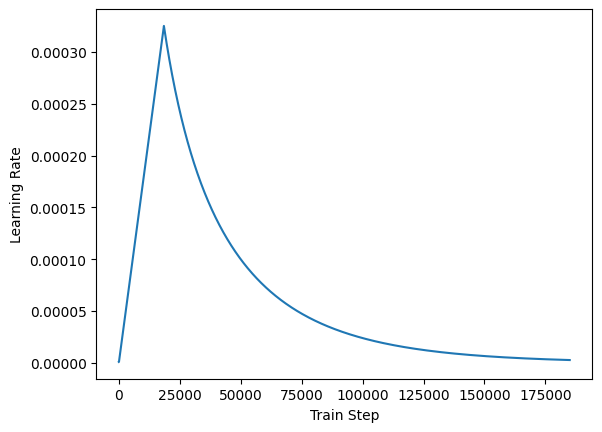

In [39]:
WARM_FRAC   = 0.1      # keep the fast ramp-up
DECAY_RATE  = 4
LR_FLOOR    = 1e-6
LR_PEAK_DESIRED = 8e-4     # choose 8e-4 or 9e-4
EPOCHS = 20

# pre-compute the scale that gives that peak
num_steps     = EPOCHS * len(text_pairs) // BATCH_SIZE
warmup_steps  = int(num_steps * WARM_FRAC)
d_model = 512
current_peak  = 1.0 / tf.sqrt(tf.cast(d_model * warmup_steps, tf.float32))
LR_SCALE      = LR_PEAK_DESIRED / current_peak.numpy()

@tf.keras.utils.register_keras_serializable()   # so it can round-trip in SavedModel/H5
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, total_steps=num_steps,
                 warmup_frac=WARM_FRAC, decay_rate=DECAY_RATE,
                 lr_scale=LR_SCALE):
        super().__init__()
        self.d_model      = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(int(total_steps * warmup_frac), tf.float32)
        self.decay_rate   = decay_rate
        self.decay_steps  = tf.cast(total_steps, tf.float32)
        # self.lr_scale     = tf.cast(lr_scale, tf.float32)

    def __call__(self, step):
        step  = tf.cast(step, tf.float32)
        arg1  = tf.math.rsqrt(step)
        arg2  = step * tf.math.pow(self.warmup_steps, -1.5)
        warm  = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        decay = tf.math.exp(-self.decay_rate *
                            tf.maximum(step - self.warmup_steps, 0.) /
                            self.decay_steps)
        lr = warm * decay #* self.lr_scale 
        return tf.maximum(lr, LR_FLOOR)

    # ----------  NEW  ----------
    def get_config(self):
        return {
            "d_model":      int(self.d_model.numpy()),   # cast back to Python types
            "total_steps":  int(self.decay_steps.numpy()),
            "warmup_frac":  float(self.warmup_steps.numpy() / self.decay_steps.numpy()),
            "decay_rate":   self.decay_rate,
            # "lr_scale":     float(self.lr_scale.numpy()),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=1.0)
    
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(num_steps, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

print(temp_learning_rate_schedule(tf.range(num_steps, dtype=tf.float32)))

In [40]:
# 2) Repack your dataset for .fit()
# Each element becomes (x, y, sample_weight)
ds_for_fit = ds.map(lambda b: (           # ds originally yields dicts
    b["input_ids"],        # x
    b["labels"],           # y_true
    b["loss_mask"]         # sample_weight: 1.0 on summary tokens, 0 elsewhere
))

model = Transformer(
    num_layers=4,
    d_model=256,
    num_heads=8,
    input_vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN, 
    dropout_rate=0.1
)

# 3) Compile with a standard sparse‐CE loss and let Keras use sample weights
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none"),
    metrics=["sparse_categorical_accuracy"]
)

# Model's output (logits) is: logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size).
# This is a tensor of logits, where for each position in the sequence, you have a score for every possible token in your vocabulary.
# Because labels are integer token IDs (e.g., [10, 54, 3, 0, 0]) and not one-hot encoded vectors (e.g., [[0..1..0], [0..1..0], ...]), SparseCategoricalAccuracy is the appropriate metric.
# It correctly compares the integer label at each timestep with the class that has the highest logit output by the model for that timestep.

# Build callbacks
callbacks = [
    EarlyStopping(monitor="loss", patience=3,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath="best_summary.keras",        # or "best_summary.h5"
        monitor="loss",
        save_best_only=True,
        verbose=1             # full model (weights + optimizer + LR schedule)
    )
]

# 4) Fit!  Keras will print epoch/step progress by default
history = model.fit(
    ds_for_fit,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1    # 1 = progress bar, loss & acc per epoch
)

Epoch 1/20


/home/krishna/VScode/Code/transformers_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_embedding_1' (of type PositionalEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  84/9249 ━━━━━━━━━━━━━━━━━━━━ 1:30:45 594ms/step - loss: 0.3232 - sparse_categorical_accuracy: 5.4865e-05

KeyboardInterrupt: 

In [ ]:
def encode_dialogue(text: str, max_len: int = MAX_LEN) -> tf.Tensor:
    """
    Returns [BOS] dialogue [EOS] *without* any padding.
    """
    tokenizer.no_padding()                         # turn padding off
    tokenizer.enable_truncation(max_length=max_len)
    ids = tokenizer.encode(text).ids               # already BOS/EOS
    return tf.constant(ids, tf.int32)              # 1-D tensor


def generate_summary(
    dialogue_ids: tf.Tensor,        # [BOS] … [EOS]  (no pads)
    model: tf.keras.Model,
    max_new: int = 120,
    temperature: float = 0.1
) -> tf.Tensor:
    """
    Produce [BOS] dialogue [SEP] summary … [EOS]
    """
    prompt = tf.concat([dialogue_ids[:-1], [sep_id]], 0)[None, :]  # add batch dim

    for _ in range(max_new):
        if prompt.shape[1] > MAX_LEN:                # keep within PE range
            break

        logits  = model.predict(prompt,verbose=False)[:, -1, :] / temperature
        next_id = tf.random.categorical(logits, 1, dtype=tf.int32)
        prompt  = tf.concat([prompt, next_id], 1)

        if next_id[0, 0] == eos_id:
            break

    return tf.squeeze(prompt, 0)

def display_text_and_summary(dialogue: str, target: str, model):
    """
    Given a raw dialogue string and a summary model, this function:
      1. Encodes the dialogue into token IDs.
      2. Generates [BOS] dialogue [SEP] summary [EOS].
      3. Splits at [SEP], decodes each part, and prints:
         - "Text: <original dialogue…>"
         - "Summary: <generated summary…>"
    """
    # 1. Encode the dialogue (adds [BOS] … [EOS])
    dlg_ids = encode_dialogue(clean_text(dialogue))

    # 2. Generate the full sequence [BOS] dialogue [SEP] summary [EOS]
    full_ids = generate_summary(dlg_ids, model)

    # 3. Convert to a plain Python list so we can find sep_id
    full_ids_list = full_ids.numpy().tolist()

    # 4. Find the position of sep_id
    sep_index = full_ids_list.index(sep_id)

    # 5. Split into dialogue_part and summary_part
    dialogue_part = full_ids_list[:sep_index]
    summary_part  = full_ids_list[sep_index + 1:]  # skip the sep_id itself

    # 6. Decode each slice
    text_str    = decode_token_ids(dialogue_part)
    summary_str = decode_token_ids(summary_part)

    # 7. Print on two lines
    print("\n Text:", text_str)
    print("\n Genrated Summary:", summary_str)
    print("\n Original Summary:", target)

In [ ]:
for j in range(5):
    print(j)
    dialogue = df1['input_txt'][j]
    summary = df1['target_txt'][j]
    display_text_and_summary(dialogue, summary, model)
    print('----------------')
